In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tqdm.notebook import tqdm

In [3]:
from mixturelib.mixture import MixtureEM

from mixturelib.hyper_models import HyperExpertNN, HyperModel, HyperModelDirichlet, HyperModelGateSparsed

from mixturelib.regularizers import RegularizeFunc

from mixturelib.local_models import EachModel, EachModelLinear

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = False

plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [6]:
np.random.seed(0)
N = 100
N_noise=0
n = 3

phi = np.linspace(0, 2*np.pi, N)

r1 = 2
x1 = 0
y1 = 0

r2 = 1
x2 = 10 + np.random.randn()
y2 = 10 + np.random.randn()

r3 = 1
x3 = -10 + np.random.randn()
y3 = 10 + np.random.randn()

r4 = 1
x4 = -10 + np.random.randn()
y4 = -10 + np.random.randn()

r5 = 1
x5 = 10 + np.random.randn()
y5 = -10 + np.random.randn()




x = np.hstack([r1*np.sin(phi) + x1, 
               r2*np.sin(phi) + x2, 
               r3*np.sin(phi) + x3,
               r4*np.sin(phi) + x4, 
               r5*np.sin(phi) + x5])
x += 0.2*np.random.randn(x.shape[0])

y = np.hstack([r1*np.cos(phi) + y1, 
               r2*np.cos(phi) + y2, 
               r3*np.cos(phi) + y3,
               r4*np.cos(phi) + y4, 
               r5*np.cos(phi) + y5])
y += 0.2*np.random.randn(y.shape[0])

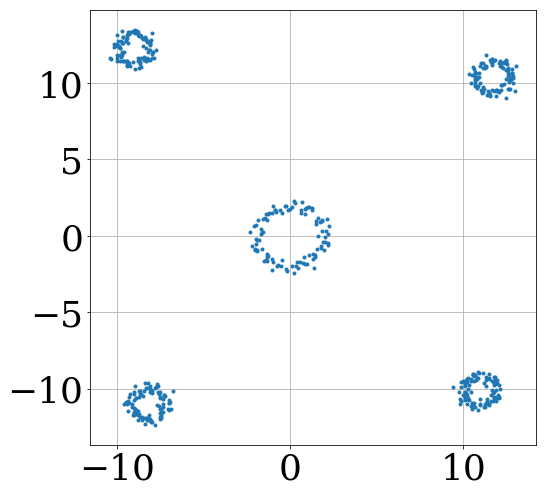

In [7]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

plt.rcParams["font.family"] = 'DejaVu Serif'

plt.rcParams['text.usetex'] = False

plt.rcParams['figure.figsize'] = (8.0, 8.0)
############################################

plt.plot(x, y, '.')

plt.grid()

plt.show()

In [8]:
X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

In [9]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([500, 3]), torch.Size([500, 1]))

In [10]:
def R(W0):
    return - ((0.5*W0[0][:2])**2).sum() \
           - ((((0.5*W0[1][0]-0.5*W0[2][0])**2).sum() - 36)**2) \
           - ((((0.5*W0[1][1]-0.5*W0[2][1])**2).sum() - 36)**2)

In [11]:
def get_S1(model):
    z = model.pZ
    log_pi = torch.log(model.HyperModel.PredictPi(X_tr, model.HyperParameters)+0.00000001)
    
    temp2 = torch.cat([model.ListOfModels[k].LogLikeLihoodExpectation(X_tr, Y_tr, model.HyperParameters) for k in range(model.K)],dim = 1)

    return (model.pZ*(log_pi+temp2)).sum().item()

def get_S1_1(model):
    z = model.pZ
    log_pi = torch.log(model.HyperModel.PredictPi(X_tr, model.HyperParameters)+0.00000001)
    return (model.pZ*(log_pi)).sum().item()

def get_S1_2(model):
    z = model.pZ
    
    temp2 = torch.cat([model.ListOfModels[k].LogLikeLihoodExpectation(X_tr, Y_tr, model.HyperParameters) for k in range(model.K)],dim = 1)

    return (model.pZ*(temp2)).sum().item()
    
def get_S2(model):
    summ = 0
    for k in range(len(model.ListOfModels)):
        A = model.ListOfModels[k].A
        if len(A.shape) == 1:
            A = torch.diag(A)
        try:
            A_inv = torch.inverse(A)
        except:
            A_inv = torch.eye(A.shape[0])

        w = model.ListOfModels[k].W
        w_0 = model.ListOfModels[k].w_0
        summ += (-0.5*(w - w_0).transpose(0, 1)@A_inv@(w - w_0) + 0.5*torch.log(torch.det(A_inv)) 
                 -0.5*len(w)*np.log(2*np.pi)).item()
    return summ

In [12]:
K = 5
LIST_A = [torch.tensor([3., 3., 1]) for _ in range(K)]
LIST_w = [torch.tensor([0., 0., 4]).view(-1,1), 
          torch.tensor([20., 20., -200]).view(-1,1), 
          torch.tensor([-20., -20., -200]).view(-1,1), 
          torch.tensor([20., -20., -200]).view(-1,1), 
          torch.tensor([-20., 20., -200]).view(-1,1)]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, 
                               device = device, 
                               A = torch.ones(3)*LIST_A[k], 
                               w = torch.ones(3, 1)*LIST_w[k],
                               OptimizedHyper={}))


HypPar = {'beta': 1., 'alpha': 1e-5}


HpMd = HyperExpertNN(input_dim=n, output_dim = K, device = device, epochs=10)
# HpMd = HyperModelGateSparsed(output_dim = K, mu=torch.ones(5), device = device)


model = MixtureEM(HyperParameters = HypPar,
                  HyperModel = HpMd, 
                  ListOfModels = LoM,
                  device = device, model_type='sample')




In [13]:
list_of_S1 = []
list_of_S1_1 = []
list_of_S1_2 = []
list_of_S2 = []
list_of_beta = []
dict_of_list_of_w_0 = dict()
dict_of_list_of_W = dict()
dict_of_list_of_A = dict()

for it in tqdm(range(200)):
    model.fit(X_tr, Y_tr, 1)
    for k in range(len(model.ListOfModels)):
        if k not in dict_of_list_of_w_0:
            dict_of_list_of_w_0[k] = []
        if k not in dict_of_list_of_W:
            dict_of_list_of_W[k] = []
        if k not in dict_of_list_of_A:
            dict_of_list_of_A[k] = []

        dict_of_list_of_w_0[k].append(model.ListOfModels[k].w_0.numpy())
        dict_of_list_of_W[k].append(model.ListOfModels[k].W.numpy())
        dict_of_list_of_A[k].append(model.ListOfModels[k].A.numpy())
        
    list_of_S1.append(get_S1(model))
    list_of_S1_1.append(get_S1_1(model))
    list_of_S1_2.append(get_S1_2(model))
    list_of_S2.append(get_S2(model))
    list_of_beta.append(model.HyperParameters['beta'].item())

## зависимость слагаемых

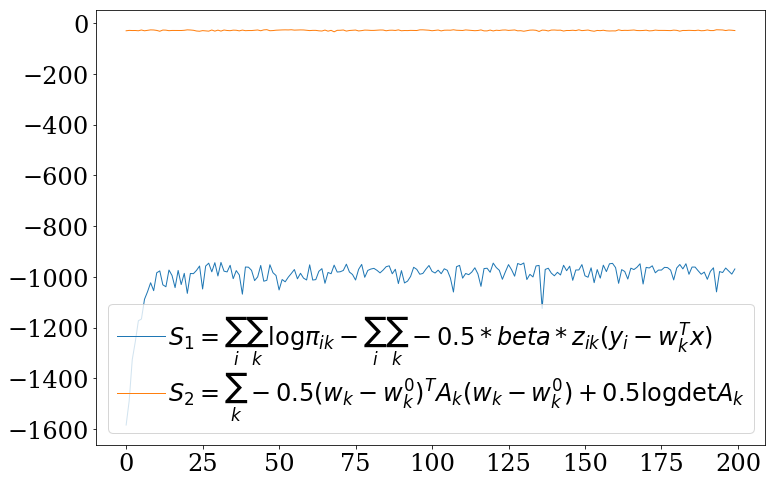

In [39]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

plt.plot(list_of_S1, label='$S_1 = \sum_{i}\sum_k\log\pi_{ik} - \sum_{i}\sum_k-0.5*beta*z_{ik}(y_i-w_k^{T}x)$')
plt.plot(list_of_S2, label='$S_2 = \sum_k -0.5(w_k-w_k^0)^{T}A_k(w_k-w_k^0) + 0.5\log\det A_k$')

plt.legend(loc='best')
plt.show()

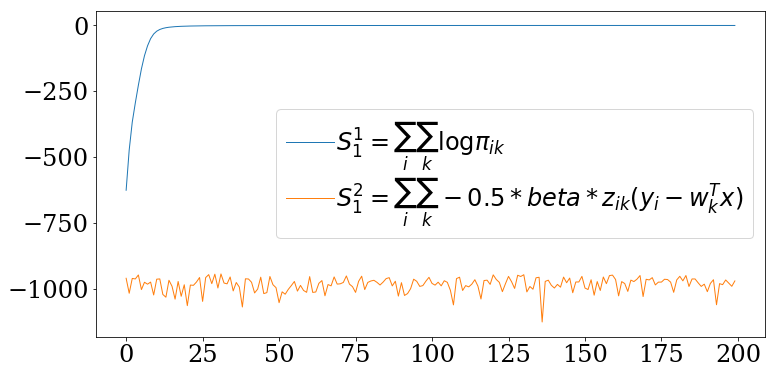

In [40]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

plt.plot(list_of_S1_1, label='$S_1^1=\sum_{i}\sum_k\log\pi_{ik}$')
plt.plot(list_of_S1_2, label='$S_1^2=\sum_{i}\sum_k-0.5*beta*z_{ik}(y_i-w_k^{T}x)$')

plt.legend(loc='best')
plt.show()

In [45]:
F.softmax(torch.tensor([-1.*10**5, -2.*10**5]), dim=0)

tensor([1., 0.])

## зависимость beta

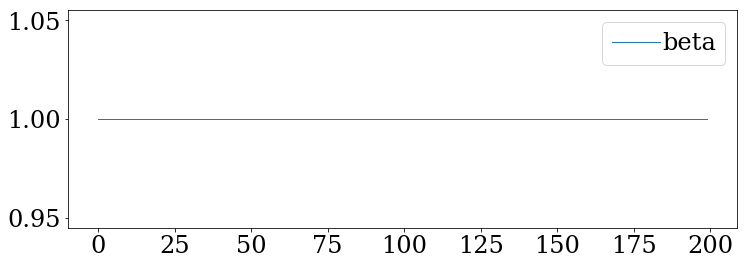

In [17]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

plt.plot(list_of_beta, label='beta')

plt.legend(loc='best')
plt.show()

## зависимость параметров моделей

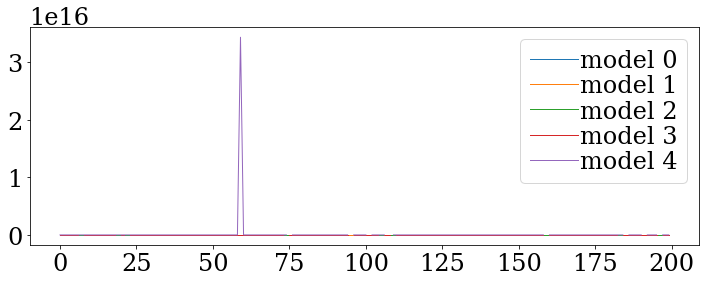

In [16]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

for k in range(len(model.ListOfModels)):
    plt.plot(list(map(np.linalg.norm, dict_of_list_of_W[k])), label='model {}'.format(k))
    
plt.legend(loc='best')
plt.show()

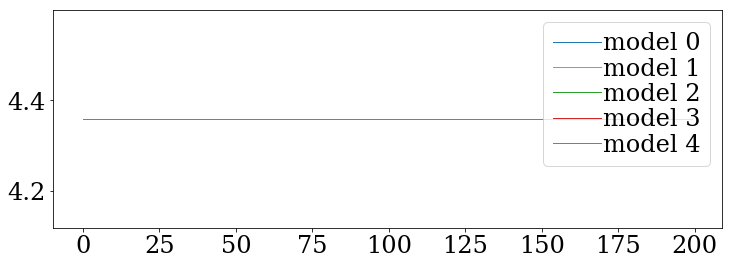

In [17]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

for k in range(len(model.ListOfModels)):
    plt.plot(list(map(np.linalg.norm, dict_of_list_of_A[k])), label='model {}'.format(k))
    
plt.legend(loc='best')
plt.show()

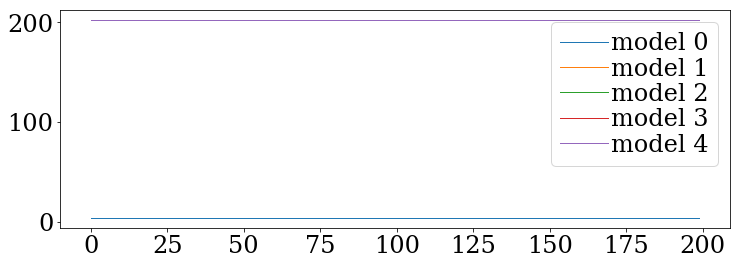

In [18]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

for k in range(len(model.ListOfModels)):
    plt.plot(list(map(np.linalg.norm, dict_of_list_of_w_0[k])), label='model {}'.format(k))
    
plt.legend(loc='best')
plt.show()

In [19]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

TEMP

array([[ 7.6495171e-02, -1.8975957e-01,  3.9117672e+00],
       [ 2.1683010e+01,  1.8689379e+01, -2.0228761e+02],
       [-1.6982765e+01, -2.2657997e+01, -1.9942880e+02],
       [ 2.1057167e+01, -1.9123343e+01, -2.0086464e+02],
       [-1.6566799e+01,  2.3166330e+01, -2.0089539e+02]], dtype=float32)

In [20]:
W0 = np.array([m.w_0.data.numpy().reshape(-1) for m in model.ListOfModels])

W0

array([[   0.,    0.,    4.],
       [  20.,   20., -200.],
       [ -20.,  -20., -200.],
       [  20.,  -20., -200.],
       [ -20.,   20., -200.]], dtype=float32)

In [21]:
CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = 0.5*param[:2]
    r = (param[2] + x0**2 + y0**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

array([[  0.03824759,  -0.09487978,   1.9804627 ],
       [ 10.841505  ,   9.344689  ,   1.6043186 ],
       [ -8.491383  , -11.328999  ,   1.0104377 ],
       [ 10.528584  ,  -9.561671  ,   1.1882714 ],
       [ -8.2834    ,  11.583165  ,   1.3744229 ]], dtype=float32)

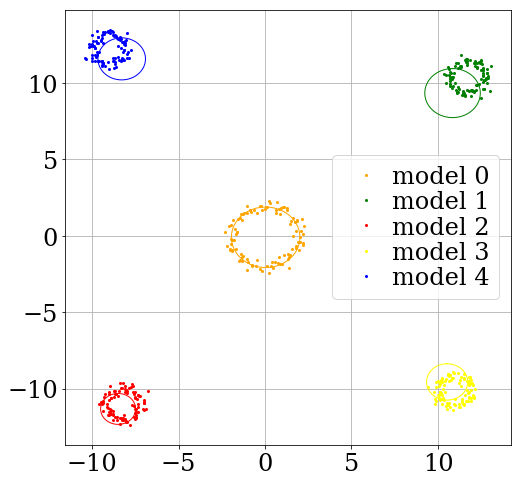

In [22]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yellow', 'blue']

for i in range(len(model.ListOfModels)):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')

plt.show()